In [1]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook
from sklearn.linear_model import LogisticRegression
import sklearn.model_selection
import sklearn.preprocessing as preproc
from sklearn.feature_extraction import text
import pickle
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Source of dataset: http://snap.stanford.edu/data/web-FineFoods.html

df = pd.read_csv('Reviews.csv', index_col=0)
df = df.dropna()

In [4]:
df.shape

(568411, 9)

In [5]:
df.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
Id,,,,,,,,,
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
df.drop_duplicates(subset={'UserId', 'ProfileName', 'Time', 'Text'}, inplace=True)

In [7]:
df.shape

(393919, 9)

<IPython.core.display.Javascript object>


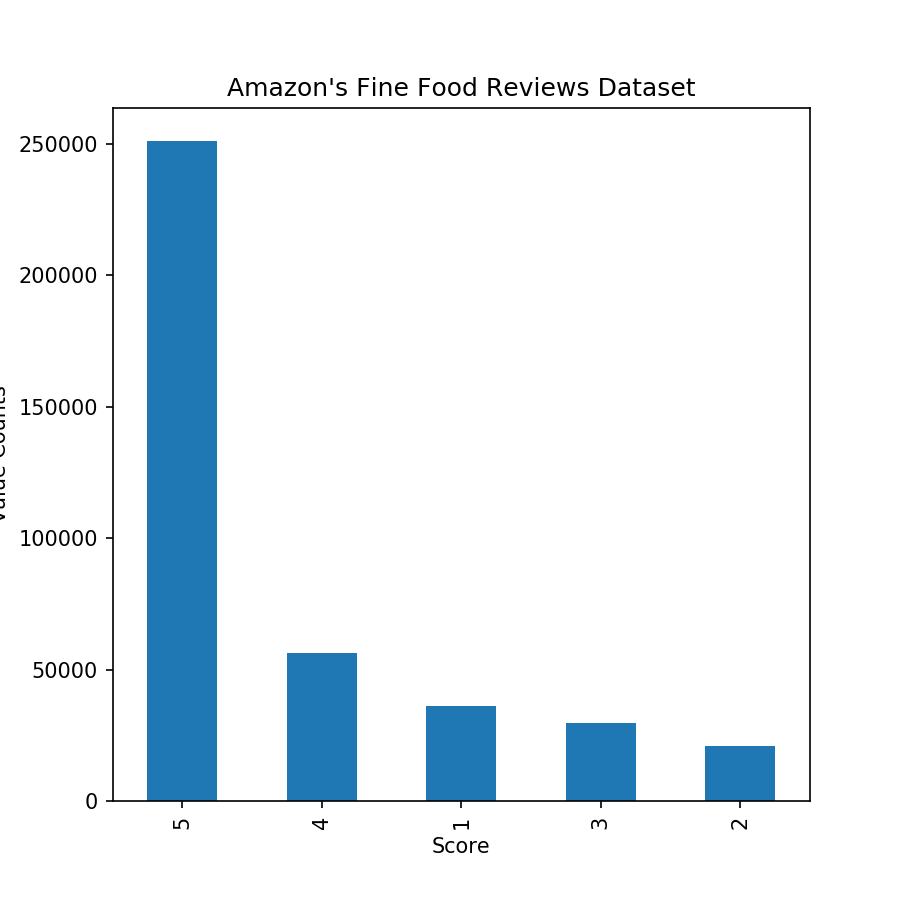

In [8]:
ax = df['Score'].value_counts().plot(kind='bar', figsize=(6,6))
fig = ax.get_figure()
ax.set_title("Amazon's Fine Food Reviews Dataset")
ax.set_xlabel('Score')
ax.set_ylabel('Value Counts');

In [9]:
df['Label'] = 0
df.loc[df['Score'] > 3, ['Label']] = 1

In [10]:
len(df[df['Label'] == 1])/len(df)

0.7794724296111637

In [11]:
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [12]:
def clean_text(text, remove_stopwords = True):
    '''Remove unwanted characters, stopwords, and format the text to create fewer nulls word embeddings'''
    
    # Convert words to lower case
    text = text.lower()
    
    # Replace contractions with their longer forms 
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    
    # remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    # Tokenize each word
    text =  nltk.WordPunctTokenizer().tokenize(text)
        
    return text

In [13]:
df['Text_Cleaned'] = list(map(clean_text, df.Text))

In [14]:
def lemmatized_words(text):
    lemm = nltk.stem.WordNetLemmatizer()
    df['lemmatized_text'] = list(map(lambda word:
                                     list(map(lemm.lemmatize, word)),
                                     df.Text_Cleaned))
    

lemmatized_words(df.Text_Cleaned)

In [15]:
df.head(3)

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Label,Text_Cleaned,lemmatized_text
Id,,,,,,,,,,,,
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1,"[bought, several, vitality, canned, dog, food,...","[bought, several, vitality, canned, dog, food,..."
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0,"[product, arrived, labeled, jumbo, salted, pea...","[product, arrived, labeled, jumbo, salted, pea..."
3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1,"[confection, around, centuries, light, pillowy...","[confection, around, century, light, pillowy, ..."


In [16]:
pd.set_option('max_colwidth', 500)
df[['Score', 'Text', 'Label', 'Text_Cleaned', 'lemmatized_text']].sample(3)

,Score,Text,Label,Text_Cleaned,lemmatized_text
Id,,,,,
63527,4,"Usually I like my coffee hot. Part of the ritual of waking up was that aroma of freshly brewing coffee. But the work schedule has changed to mostly nights , and since the wife and I are now only opposite schedules , making a whole pot in the morning is wasteful.<br />But I still need a boost in the afternoon , and a coworker suggested this. Glad she did. Turns out cold coffee is just as satisfying as hot coffee. The 6.8 oz size seems like just the right amount , and with no significant after...",1,"[usually, like, coffee, hot, part, ritual, waking, aroma, freshly, brewing, coffee, work, schedule, changed, mostly, nights, since, wife, opposite, schedules, making, whole, pot, morning, wasteful, <, br, >, but, still, need, boost, afternoon, coworker, suggested, glad, turns, cold, coffee, satisfying, hot, coffee, 6, 8, oz, size, seems, like, right, amount, significant, aftertaste, see, fast, becoming, part, afternoon, ritual, staying, awake]","[usually, like, coffee, hot, part, ritual, waking, aroma, freshly, brewing, coffee, work, schedule, changed, mostly, night, since, wife, opposite, schedule, making, whole, pot, morning, wasteful, <, br, >, but, still, need, boost, afternoon, coworker, suggested, glad, turn, cold, coffee, satisfying, hot, coffee, 6, 8, oz, size, seems, like, right, amount, significant, aftertaste, see, fast, becoming, part, afternoon, ritual, staying, awake]"
224568,5,"This is a product that I can no longer find in local grocery stores. I was tickled to find that I could order it online. The price I paid was reasonable although I found it at a time it was discounted. I used my Super Saver free shipping to make it affordable to order. I had to order a box pack of 12 jars of Heinz India Relish but know that I will eventually use it!<br /><br />If you have never used this relish, you might be interested in trying it. It is not as sweet as regular pickle relis...",1,"[product, longer, find, local, grocery, stores, tickled, find, could, order, online, price, paid, reasonable, although, found, time, discounted, used, super, saver, free, shipping, make, affordable, order, order, box, pack, 12, jars, heinz, india, relish, know, eventually, use, <, br, ><, br, >, if, never, used, relish, might, interested, trying, sweet, regular, pickle, relish, great, chicken, salad, deviled, eggs, etc]","[product, longer, find, local, grocery, store, tickled, find, could, order, online, price, paid, reasonable, although, found, time, discounted, used, super, saver, free, shipping, make, affordable, order, order, box, pack, 12, jar, heinz, india, relish, know, eventually, use, <, br, ><, br, >, if, never, used, relish, might, interested, trying, sweet, regular, pickle, relish, great, chicken, salad, deviled, egg, etc]"
512683,5,"I wanted to try this style cheese just to see what the fuss is all about on those cooking shows. I had bought super market deli Parmesan for years but it always tasted a bit flat to me. Just not exciting. Anyway I splurged, I'm an old guy and simply wanted to at least have tried the ""good"" stuff at least once. I typically use the cheese grated or shaved on salads or pasta. I was amazed this stuff is too good to waste on pasta or salads, It needs to be eaten freshly cut from the piece with sl...",1,"[wanted, try, style, cheese, see, fuss, cooking, shows, bought, super, market, deli, parmesan, years, always, tasted, bit, flat, exciting, anyway, splurged, old, guy, simply, wanted, least, tried, good, stuff, least, typically, use, cheese, grated, shaved, salads, pasta, amazed, stuff, good, waste, pasta, salads, needs, eaten, freshly, cut, piece, sliced, raw, apple, pear, savored, slowly, concentration, simply, best, ever, anywhere, use, salads, pasta, never, able, go, back, impersonators, ...","[wanted, try, style, cheese, see, fuss, cooking, show, bought, super, market, deli, parmesan, year, always, tasted, bit, flat, exciting, anyway, splurged, o

In [17]:
bow_converter = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False)
x = bow_converter.fit_transform(df['Text_Cleaned'])

words = bow_converter.get_feature_names()
len(words)

110422

In [18]:
bigram_converter = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[2,2], lowercase=False) 
x2 = bigram_converter.fit_transform(df['Text_Cleaned'])
bigrams = bigram_converter.get_feature_names()
len(bigrams)

4189296

In [19]:
bigrams[-10:]

['× piperita',
 'â many',
 'çaykur teas',
 'çelem fermented',
 'être fort',
 'île de',
 'ît real',
 'ø lipton',
 'ø mahatma',
 'ø zatarains']

In [20]:
trigram_converter = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[3,3], lowercase=False) 
x3 = trigram_converter.fit_transform(df['Text_Cleaned'])
trigrams = trigram_converter.get_feature_names()
len(trigrams)

11572565

In [21]:
trigrams[:10]

['\x10 i wonder',
 '\x13 2852 said',
 '0 0 0',
 '0 0 4',
 '0 0 <',
 '0 0 amazon',
 '0 0 kj',
 '0 0 markets',
 '0 0 official',
 '0 0 zero']

In [22]:
print(len(words), len(bigrams), len(trigrams))

110422 4189296 11572565


<IPython.core.display.Javascript object>


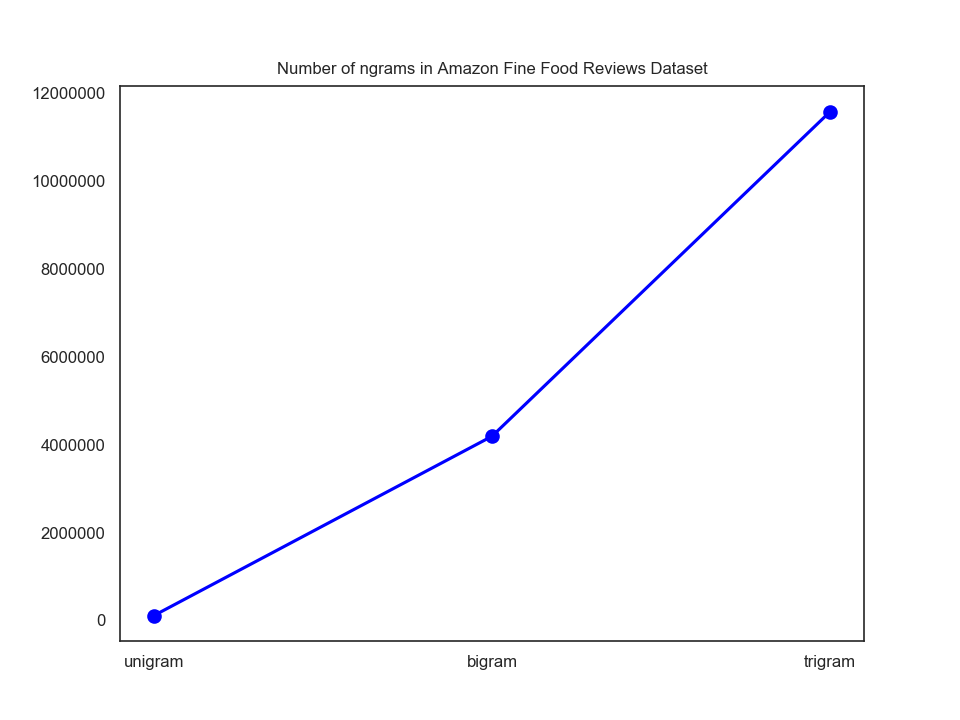

In [24]:
sns.set_style("white")
counts = [len(words), len(bigrams), len(trigrams)]
plt.plot(counts, color='blue')
plt.plot(counts, 'bo')
#plt.margins(0.1)
plt.ticklabel_format(style = 'plain')
plt.xticks(range(3), ['unigram', 'bigram', 'trigram'])
plt.tick_params(labelsize=8)
plt.title('Number of ngrams in Amazon Fine Food Reviews Dataset', {'fontsize':8})
plt.show()

In [25]:
training_data, test_data = sklearn.model_selection.train_test_split(df, train_size = 0.7, random_state=42)

In [26]:
print(training_data.shape)
print(test_data.shape)

(275743, 12)
(118176, 12)


In [27]:
bow_transform = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[3,3], lowercase=False)

In [28]:
X_tr_bow = bow_transform.fit_transform(training_data['Text_Cleaned'])

In [29]:
len(bow_transform.vocabulary_)

8381084

In [30]:
X_tr_bow.shape

(275743, 8381084)

In [31]:
X_te_bow = bow_transform.transform(test_data['Text_Cleaned'])

In [32]:
y_tr = training_data['Label']
y_te = test_data['Label']

In [33]:
tfidf_transform = text.TfidfTransformer(norm=None)
X_tr_tfidf = tfidf_transform.fit_transform(X_tr_bow)

In [34]:
X_te_tfidf = tfidf_transform.transform(X_te_bow)

In [35]:
def simple_logistic_classify(X_tr, y_tr, X_test, y_test, description, _C=1.0):
    model = LogisticRegression(C=_C).fit(X_tr, y_tr)
    score = model.score(X_test, y_test)
    print('Test Score with', description, 'features', score)
    return model

In [36]:
model_bow = simple_logistic_classify(X_tr_bow, y_tr, X_te_bow, y_te, 'bow')
model_tfidf = simple_logistic_classify(X_tr_tfidf, y_tr, X_te_tfidf, y_te, 'tf-idf')

Test Score with bow features 0.8083367181153533
Test Score with tf-idf features 0.8154024505821825


In [37]:
param_grid_ = {'C': [1e-5, 1e-3, 1e-1, 1e0, 1e1, 1e2]}
bow_search = sklearn.model_selection.GridSearchCV(LogisticRegression(), cv=5, param_grid=param_grid_)
tfidf_search = sklearn.model_selection.GridSearchCV(LogisticRegression(), cv=5,
                                   param_grid=param_grid_)

In [ ]:
bow_search.fit(X_tr_bow, y_tr)

In [ ]:
bow_search.best_score_

In [ ]:
tfidf_search.fit(X_tr_tfidf, y_tr)

In [ ]:
tfidf_search.best_score_

In [ ]:
bow_search.best_params_

In [ ]:
tfidf_search.best_params_

In [ ]:
bow_search.cv_results_

In [ ]:
results_file = open('tfidf_gridcv_results.pkl', 'wb')
pickle.dump(bow_search, results_file, -1)
pickle.dump(tfidf_search, results_file, -1)
results_file.close()

In [ ]:
pkl_file = open('tfidf_gridcv_results.pkl', 'rb')
bow_search = pickle.load(pkl_file)
tfidf_search = pickle.load(pkl_file)
pkl_file.close()

In [ ]:
search_results = pd.DataFrame.from_dict({'bow': bow_search.cv_results_['mean_test_score'],
                               'tfidf': tfidf_search.cv_results_['mean_test_score']})
search_results

In [ ]:
%matplotlib inline
ax = sns.boxplot(data=search_results, width=0.4)
ax.set_ylabel('Accuracy', size=14)
ax.tick_params(labelsize=14)
plt.savefig('tfidf_gridcv_results.png')

In [ ]:
model_bow = simple_logistic_classify(X_tr_bow, y_tr, X_te_bow, y_te, 'bow', 
                              _C=bow_search.best_params_['C'])
model_tfidf = simple_logistic_classify(X_tr_tfidf, y_tr, X_te_tfidf, y_te, 'tf-idf', 
                              _C=tfidf_search.best_params_['C'])